## Evaluate Geonet

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# # DRIVE
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.decision.reconstruction import binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.2.0


Using TensorFlow backend.
'nvidia-smi' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


## Import data

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 0

# validation set
x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-1000], y_train[np.where(y_train[:-1000] == interest_digit)][:-1000]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)


In [24]:
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from itertools import product

def plot_images(images_arr):
    fig, axes = plt.subplots(4, 5, figsize=(20,6))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(np.squeeze(img, -1))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# renvoyer une image a la fois? Tout un batch?
# Comment preciser exctement les trasnformations que je veux faire?
# Comment appliquer chaque transformation individuellement?


class MNISTSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, augmentations):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = augmentations

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.stack([self.augment(image=x)["image"] for x in batch_x], axis=0),
               np.array(batch_y)
        

from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=1),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, 
                     border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    p=1.0])

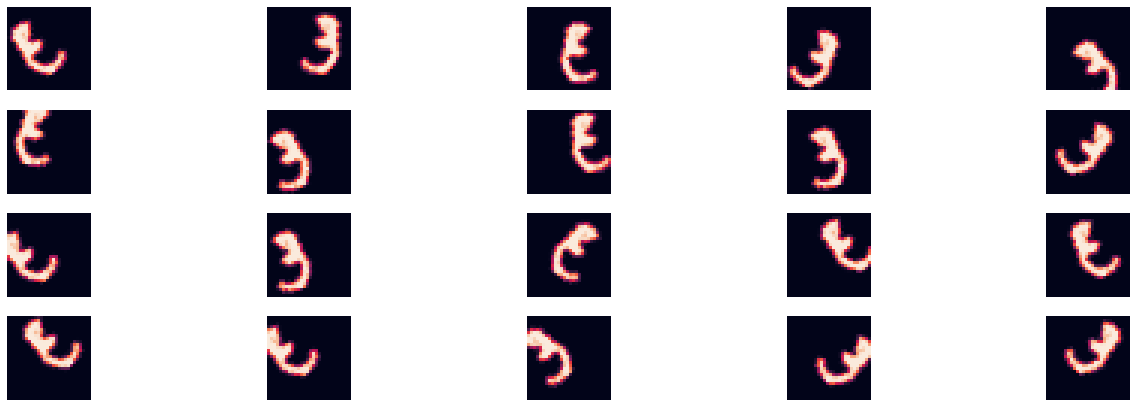

In [25]:
image_generator = ImageDataGenerator(preprocessing_function=prepro)

train_data_gen = image_generator.flow(x_train[:20], batch_size=64)

augmented_images = [train_data_gen[0][0] for i in range(20)]
plot_images(augmented_images)